CNN-LSTM for Multivariate Stock Price Forecasting

This notebook demonstrates a hybrid deep learning architecture — CNN-LSTM — for predicting Google’s stock closing prices based on 30-day windows of historical data. Unlike standard LSTMs, this model combines convolutional layers (to extract local temporal patterns) with recurrent LSTM layers (to capture long-term dependencies).

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Google_stock_data[1].csv to Google_stock_data[1].csv
User uploaded file "Google_stock_data[1].csv" with length 493042 bytes


In [6]:
# Import Dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the Dataset
file_path = "Google_stock_data[1].csv"  # Make sure this file is uploaded in the runtime

# Read the CSV file
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select Features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]

# Normalize the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences for CNN-LSTM
# Split each 30-day window into 5 sub-sequences of 6 days each
def create_cnn_lstm_sequences(data, window_size=30, subseq=5):
    step = window_size // subseq
    X, y = [], []
    for i in range(window_size, len(data)):
        window = data[i-window_size:i]
        reshaped = window.reshape((subseq, step, data.shape[1]))
        X.append(reshaped)
        y.append(data[i, 3])  # Close price
    return np.array(X), np.array(y)

window_size = 30
subseq = 5
X, y = create_cnn_lstm_sequences(scaled_data, window_size, subseq)

# Train-Test Split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4685, 5, 6, 5)
Testing set shape: (521, 5, 6, 5)


In [7]:
# Build and Train CNN-LSTM Model
model = Sequential([
    TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'), input_shape=(subseq, X.shape[2], X.shape[3])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7114e-04 - val_loss: 0.0012
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3038e-04 - val_loss: 0.0014
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0667e-04 - val_loss: 0.0018
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.5520e-04 - val_loss: 9.9257e-04
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.1985e-04 - val_loss: 0.0014
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7958e-04 - val_loss: 0.0019
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4662e-04 - val_loss: 0.0026
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6270e-04 - val_loss: 0.0012
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1418e-04 - val_loss: 0.0015
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1230e-04 - val_loss: 0.0024
Epoch 12/50
147/1

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
CNN-LSTM RMSE: 4.21
CNN-LSTM MAE: 3.22


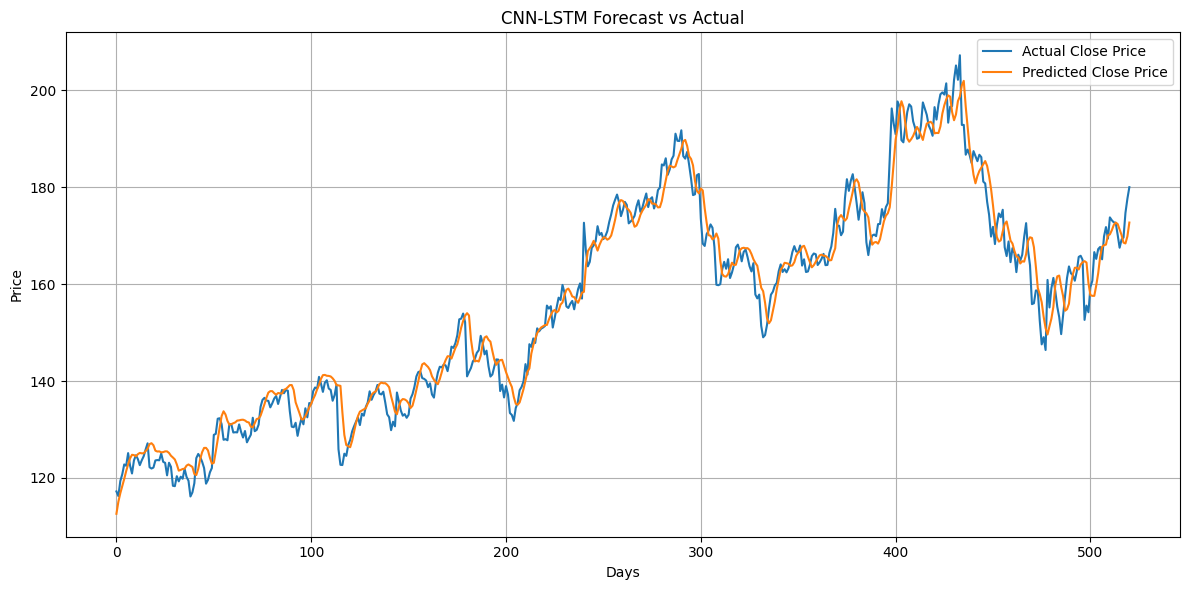

In [8]:
# Evaluate the Model
# Predict on test set
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse transform predictions (replacing Close in scaled dataset)
def inverse_transform_close(pred_close_scaled):
    dummy = np.zeros((len(pred_close_scaled), 5))
    dummy[:, 3] = pred_close_scaled.ravel()
    return scaler.inverse_transform(dummy)[:, 3]

predicted_close = inverse_transform_close(y_pred_scaled)
actual_close = inverse_transform_close(y_test_scaled)

# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"CNN-LSTM RMSE: {rmse:.2f}")
print(f"CNN-LSTM MAE: {mae:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title('CNN-LSTM Forecast vs Actual')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


While not outperforming the plain LSTM model, this experiment shows how hybrid models can be structured for multivariate time series forecasting.